In [1]:

!pip install pulp numpy pandas matplotlib > /dev/null

In [2]:

import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [3]:
# === PARAMETERS ===
T = 90                # horizon (days)
LT = 7                # lead time (days)
N_SCEN = 20           # number of stochastic demand scenarios
np.random.seed(42)


In [4]:

holding_cost = 0.02   # per unit per day
stockout_cost = 5.0   # per unit unmet demand
init_inventory = 100  # initial on-hand
forecast_mean = np.linspace(40, 60, T)     # rising demand pattern
forecast_std = np.linspace(5, 15, T)       # uncertainty increases over time


In [5]:
# === GENERATE STOCHASTIC DEMAND SCENARIOS ===
demands = np.zeros((N_SCEN, T))
for s in range(N_SCEN):
    demands[s, :] = np.random.normal(forecast_mean, forecast_std)
    demands[s, :] = np.maximum(demands[s, :], 0)  # no negative demand


In [6]:
# === BUILD STOCHASTIC LINEAR PROGRAM ===
model = pulp.LpProblem("Stochastic_Inventory_Optimization", pulp.LpMinimize)


In [7]:
# Decision vars
order = pulp.LpVariable.dicts("order", range(T), lowBound=0, cat="Continuous")
# Scenario-dependent inventory and backorders
I = pulp.LpVariable.dicts("I", [(s,t) for s in range(N_SCEN) for t in range(T)], lowBound=0)
B = pulp.LpVariable.dicts("B", [(s,t) for s in range(N_SCEN) for t in range(T)], lowBound=0)


In [8]:
# Objective: expected total cost
model += (1/N_SCEN) * pulp.lpSum([
    holding_cost * I[(s,t)] + stockout_cost * B[(s,t)]
    for s in range(N_SCEN) for t in range(T)
]) 

In [10]:
from pulp import lpSum

for s in range(N_SCEN):
    for t in range(T):
        # arrivals from orders placed LT days ago
        arrival_from_past = order[t-LT] if t - LT >= 0 else 0
        if t == 0:
            prev_I = init_inventory
            prev_B = 0
        else:
            prev_I = I[(s, t-1)]
            prev_B = B[(s, t-1)]
        d = demands[s, t]

        # Ensure everything is wrapped correctly
        lhs = lpSum([prev_I]) + (arrival_from_past if t - LT >= 0 else 0) - d
        rhs = I[(s, t)] - B[(s, t)]

        model += (lhs == rhs), f"balance_s{s}_t{t}"


In [11]:
# === SOLVE ===
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[model.status])

orders = np.array([order[t].value() for t in range(T)])
total_cost = pulp.value(model.objective)
print(f"✅ Optimal expected total cost: {total_cost:,.2f}")


Status: Optimal
✅ Optimal expected total cost: 1,061.12


In [12]:
# === SIMULATE INVENTORY UNDER OPTIMAL POLICY ===
def simulate(policy_orders, demand_path):
    I = np.zeros(T)
    B = np.zeros(T)
    I[0] = init_inventory
    for t in range(T):
        if t - LT >= 0:
            I[t] += policy_orders[t - LT]
        I[t] = max(I[t] - demand_path[t], 0)
        if I[t] < demand_path[t]:
            B[t] = demand_path[t] - I[t]
    return I, B

In [13]:


# Simulate median scenario
I_sim, B_sim = simulate(orders, forecast_mean)

In [17]:
orders_plot = [o if o is not None else 0 for o in orders]


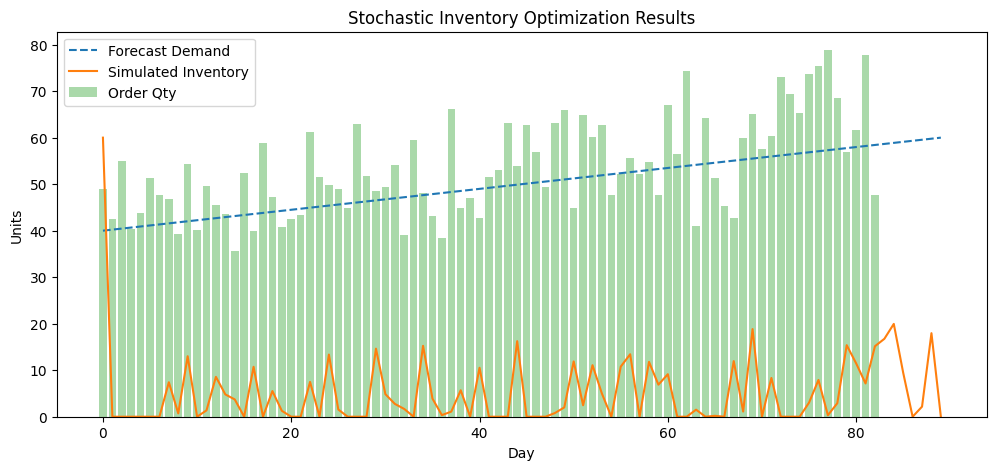

In [18]:
plt.figure(figsize=(12,5))
plt.plot(forecast_mean, label="Forecast Demand", color="tab:blue", linestyle='--')
plt.bar(np.arange(T), orders_plot, label="Order Qty", color="tab:green", alpha=0.4)
plt.plot(I_sim, label="Simulated Inventory", color="tab:orange")
plt.xlabel("Day")
plt.ylabel("Units")
plt.legend()
plt.title("Stochastic Inventory Optimization Results")
plt.show()


In [22]:

# Clean up None values
orders_clean = np.array([o if o is not None else 0 for o in orders])

# === SUMMARY ===
print("\n--- Optimal Policy Summary ---")
print(f"Total orders placed: {orders_clean.sum():.1f}")
print(f"Average daily order: {orders_clean.mean():.2f}")
print(f"Days with orders: {np.count_nonzero(orders_clean)}")
print(f"Mean on-hand (simulated): {np.mean(I_sim):.2f}")
print(f"Max inventory (simulated): {np.max(I_sim):.2f}")



--- Optimal Policy Summary ---
Total orders placed: 4458.2
Average daily order: 49.54
Days with orders: 83
Mean on-hand (simulated): 5.26
Max inventory (simulated): 60.00
